## Análise e Ciência de Dados: Acidentes nos EUA (2016-2023)

#### Este notebook tem como objetivo realizar uma análise abrangente e exploratória dos acidentes de trânsito nos EUA de 2016 a 2023.

## Objetivos

- Explorar as tendências e padrões nos acidentes de trânsito durante o período especificado.
- Identificar os fatores que contribuem para a ocorrência e gravidade dos acidentes.
- Construir modelos preditivos para prever a gravidade dos acidentes com base em diversas características.


#### Créditos

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. <a href="https://arxiv.org/abs/1906.05409"> “A Countrywide Traffic Accident Dataset.”</a>, 2019.

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. <a href="https://arxiv.org/abs/1909.09638">"Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights."</a> In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
!pip install us xgboost

In [29]:
import folium
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import us
from folium.plugins import HeatMap, MarkerCluster
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [5]:
# Lendo o dataset

df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


## Análise Exploratória dos Dados e Tratamento de valores nulos

In [7]:
df.dtypes

ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump      

In [8]:
df.isnull().sum()

ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  220377
End_Lng                  220377
Distance(mi)                  0
Description                   1
Street                      691
City                         19
County                        0
State                         0
Zipcode                     116
Country                       0
Timezone                    507
Airport_Code               1446
Weather_Timestamp          7674
Temperature(F)            10466
Wind_Chill(F)            129017
Humidity(%)               11130
Pressure(in)               8928
Visibility(mi)            11291
Wind_Direction            11197
Wind_Speed(mph)           36987
Precipitation(in)        142616
Weather_Condition         11101
Amenity                       0
Bump                          0
Crossing

In [9]:
# Excluindo colunas que não serão necessárias para a análise

drop = [
    'End_Lat',
    'End_Lng',
    'Distance(mi)',
    'Street',
    'County',
    'Zipcode',
    'Timezone',
    'Airport_Code',
    'Weather_Timestamp',
    'Visibility(mi)',
    'Wind_Direction',
    'Wind_Speed(mph)',
    'Precipitation(in)',
    'Weather_Condition',
    'Sunrise_Sunset',
    'Civil_Twilight',
    'Nautical_Twilight',
    'Astronomical_Twilight',
    'Temperature(F)',
    'Wind_Chill(F)',
    'Humidity(%)',
    'Pressure(in)'
]

df = df.drop(drop, axis=1)

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,False,True,False
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,False
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,False,True,False
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,False
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,False


In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

ID                 0
Source             0
Severity           0
Start_Time         0
End_Time           0
Start_Lat          0
Start_Lng          0
Description        0
City               0
State              0
Country            0
Amenity            0
Bump               0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

In [12]:
df.head(2)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,False,True,False
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,False


In [32]:
# Vendo o número de acidentes por gravidade

df['Severity'].value_counts()

Severity
2    398126
3     84518
4     13062
1      4274
Name: count, dtype: int64

### Função para recuperar o nome completo de cada estado em inglês a partir de sua abreviação e salvá-lo em um novo dataframe.

In [15]:
def get_state_name(abbreviation):
    if abbreviation is not None:
        state_obj = us.states.lookup(abbreviation)
        return state_obj.name if state_obj is not None else None
    else:
        return None

df['State_Name'] = df['State'].apply(get_state_name)

df.to_csv('US_Accidents_Updated.csv', index=False)

df


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,True,False,Louisiana
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,Virginia
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,True,False,California
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,Minnesota
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,A-6077227,Source1,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,Stationary traffic on OR-47 from NW Martin Rd ...,Forest Grove,OR,...,False,False,False,False,False,False,False,False,False,Oregon
499996,A-6323243,Source1,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,Incident on MILITARY TRL near WESTGATE AVE Dri...,West Palm Beach,FL,...,False,False,False,False,False,False,False,False,False,Florida
499997,A-3789256,Source1,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,Crash on the right shoulder on E SR-69 Northbo...,Dewey,AZ,...,False,False,False,False,False,False,False,True,False,Arizona
499998,A-7030381,Source1,3,2020-05-15 17:20:56,2020-05-15 17:50:56,38.406680,-78.619310,At US-340/S Stuart Ave - Serious accident.,Elkton,VA,...,False,False,False,False,False,False,False,True,False,Virginia


### Trabalhando no dataframe atualizado

In [17]:
df_updated = pd.read_csv('US_Accidents_Updated.csv')
df_updated.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,True,False,Louisiana
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,Virginia
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,True,False,California
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,Minnesota
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,California


### Questão 1: Quantos acidentes por ano e por mês, e quais conclusões podemos tirar disso?

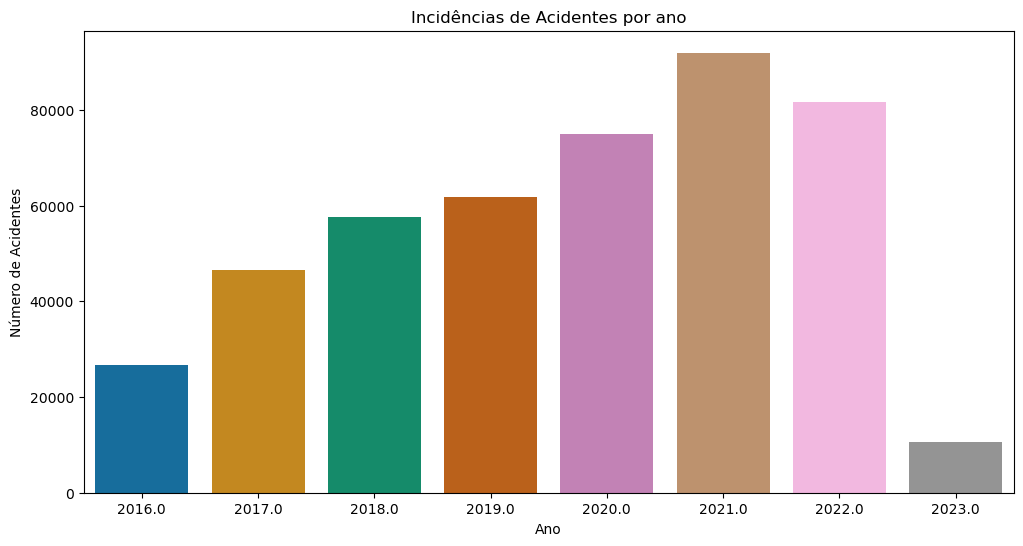

In [18]:
# Filtrando os acidentes por ano e plotando em um gráfico

df_copy_date = df_updated.copy()

df_copy_date['Start_Time'] = pd.to_datetime(df_copy_date['Start_Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

df_copy_date['Year'] = df_copy_date['Start_Time'].dt.year

yearly_counts = df_copy_date['Year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='colorblind')
plt.title('Incidências de Acidentes por ano')
plt.xlabel('Ano')
plt.ylabel('Número de Acidentes')
plt.show()

* Observamos um crescimento constante no número de acidentes de 2016 a 2021, possivelmente atribuído ao aumento da indústria automobilística e das vendas de veículos.

* Uma observação interessante é que eu esperava uma diminuição nos acidentes em 2020 devido à pandemia e à menor quantidade de pessoas nas ruas. No entanto, o gráfico mostra o contrário.

* Vale ressaltar que os dados para 2023 carecem de contexto suficiente, pois o conjunto de dados cobre apenas até março de 2023.


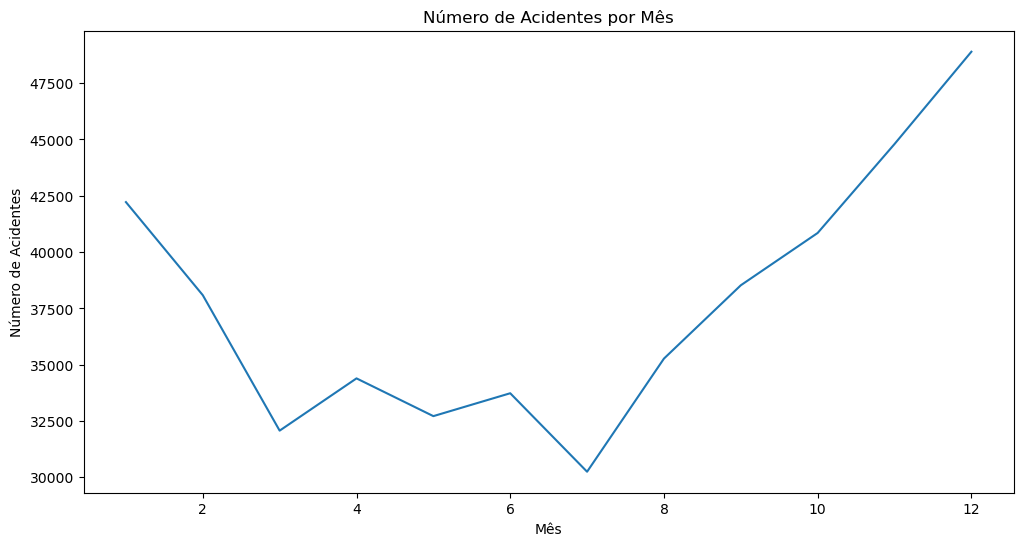

In [20]:
#Filtrando os acidentes por mês e plotando em um gráfico

df_copy_date['Month'] = df_copy_date['Start_Time'].dt.month

monthly_counts = df_copy_date['Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_counts.plot()
plt.title('Número de Acidentes por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Acidentes')
plt.show()

* Analisando os dados mensais, observamos um aumento no número de acidentes a partir do segundo semestre, com um pico ainda maior em direção ao final do ano. Também há uma diminuição durante o verão, quando as pessoas tendem a usar seus veículos menos para deslocamentos diários, como ir para o trabalho.

* Outra conclusão que podemos tirar desse padrão é que pode haver fatores sazonais influenciando a frequência de acidentes. Por exemplo, durante os meses mais frios, condições climáticas adversas como chuva ou neve podem contribuir para um aumento nos acidentes. Por outro lado, durante os meses de verão, as pessoas podem estar mais inclinadas a viajar para férias, levando a uma diminuição nos acidentes localmente.


### Questão 2: Quais são os locais com mais acidentes?

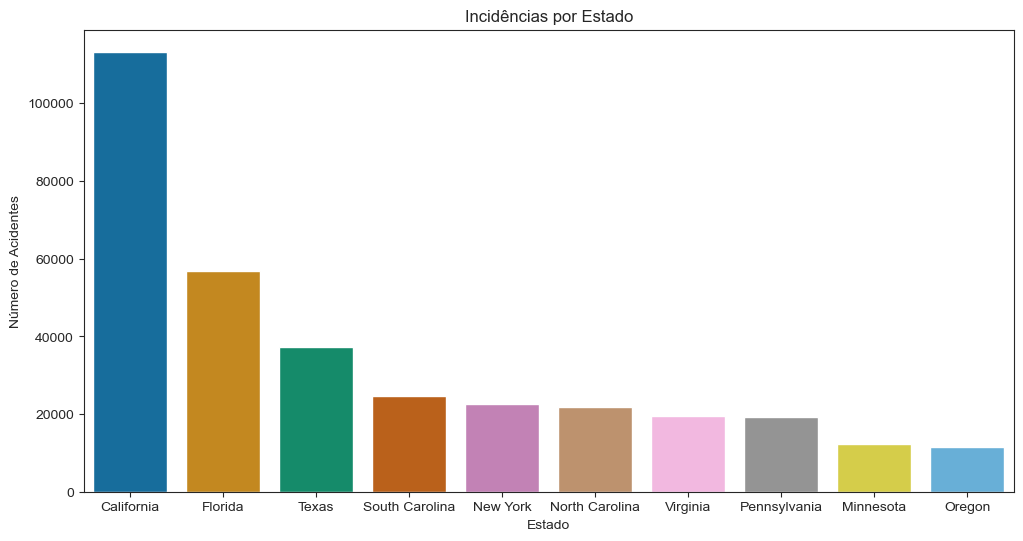

In [21]:
state_counts = df_updated['State_Name'].value_counts().head(10)

sns.set_style('ticks')
sns.set_palette('colorblind')

plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='colorblind')
plt.title('Incidências por Estado')
plt.xlabel('Estado')
plt.ylabel('Número de Acidentes')
plt.show()

* Isso sugere que estados como Califórnia, Flórida e Texas têm a maior incidência de acidentes.

* Esse padrão poderia indicar vários fatores que contribuem para taxas de acidentes mais altas nesses estados, como densidades populacionais mais altas, mais congestionamento de tráfego, diferentes culturas ou comportamentos de direção, ou condições variadas de infraestrutura viária.


### Questão 3: Quais características e fatores de trânsito são mais prevalentes nos acidentes?

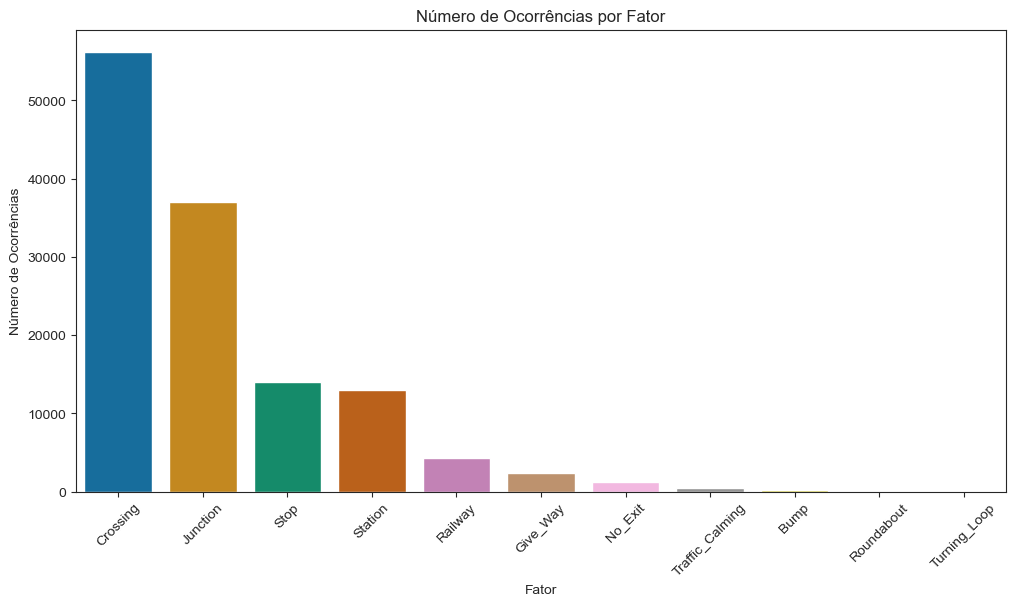

In [23]:
counts = df_updated[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                     'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                     'Turning_Loop']].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=counts.index, y=counts.values, palette='colorblind')
plt.title('Número de Ocorrências por Fator')
plt.xlabel('Fator')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.show()

### Tradução:
- **'Crossing'** - Cruzamento
- **'Stop'** - Parada
- **'Junction'** - Interseção
- **'Station'** - Estação
- **'Railway'** - Ferrovia
- **'Give_Way'** - Cedência de Passagem
- **'No_Exit'** - Sem Saída
- **'Traffic_Calming'** - Redutor de Velocidade
- **'Bump'** - Quebra-Molas
- **'Roundabout'** - Rotatória
- **'Turning_Loop'** - Retorno

* Recursos como **cruzamento, interseção, parada e estação** são os mais recorrentes porque estão frequentemente associados a locais onde ocorrem interações complexas entre veículos, como interseções (cruzamento) e junções (interseção), locais onde os veículos devem parar (parada), ou locais de embarque e desembarque de passageiros (estação). Portanto, é natural que esses recursos tenham uma alta incidência em acidentes devido à maior probabilidade de conflitos e interações entre veículos.

### Questão 4: É possível criar um modelo de Machine Learning capaz de prever a severidade dos acidentes baseados em características como duração, e fatores de trânsito?

#### Correlação entre Gravidade e Fatores

In [24]:
df_corr = df_updated[['Severity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Turning_Loop']]
df_corr.head()

,Severity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Turning_Loop
0,2,False,False,False,False,False,False,False,False,False,False,False
1,2,False,False,False,False,False,False,False,False,False,False,False
2,2,False,False,False,False,False,False,False,False,False,False,False
3,2,False,False,False,False,False,False,False,False,False,False,False
4,2,False,False,False,False,False,False,False,False,False,False,False


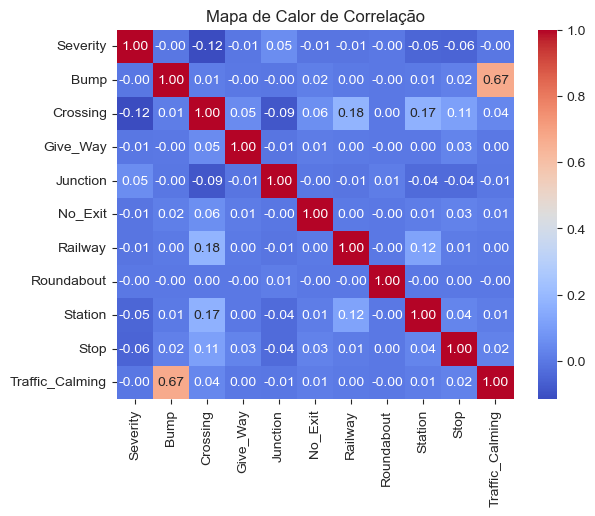

In [25]:
correlation = df_corr.drop(columns=['Turning_Loop']).corr(method='spearman')

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlação')
plt.show()

* Características como **Crossing** (Cruzamento), **Junction** (Interseção), **Station** (Estação) e **Stop** (Parada) têm correlações moderadamente negativas com a gravidade, o que pode indicar que ocorrências com essas características estão associadas a acidentes menos graves.

<br>

* Características como **Bump** (Quebra-Molas), **Give_Way** (Cedência de Passagem), **No_Exit** (Sem Saída), **Railway** (Ferrovia), **Roundabout** (Rotatória) e **Traffic_Calming** (Redutor de Velocidade) têm correlações muito fracas com a gravidade. Isso pode sugerir que essas características podem não ter um impacto significativo na gravidade dos acidentes.

<br>

* No geral, embora algumas características mostrem correlações modestas com a gravidade, **é importante lembrar que correlação não implica causalidade.** Mais análises e modelagem são necessárias para entender a relação precisa entre essas características e a gravidade dos acidentes.

#### Preparando os dados para a criação modelo XGBClassifier para prever a severidade do acidente baseado em certas circunstâncias.

In [26]:
# Convertendo as colunas de data para datetime para obter a duração do acidente

df_copy_date2 = df_updated.copy()

df_copy_date2['Start_Time'] = pd.to_datetime(df_copy_date2['Start_Time'], format='ISO8601')
df_copy_date2['End_Time'] = pd.to_datetime(df_copy_date2['End_Time'], format='ISO8601')

df_copy_date2['Duration'] = df_copy_date2['End_Time'] - df_copy_date2['Start_Time']

df_copy_date2.head(2)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name,Duration
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,True,False,Louisiana,0 days 00:45:02
1,A-4694324,Source1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,Virginia,0 days 02:19:39


In [27]:
# Função para converter a duração para segundos

def convert_to_seconds(duration):
    return duration.total_seconds()

df_copy_date2['Duration'] = df_copy_date2['Duration'].apply(convert_to_seconds)

df_copy_date2.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name,Duration
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,True,False,Louisiana,2702.0
1,A-4694324,Source1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,Virginia,8379.0
2,A-5006183,Source1,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,True,False,California,7785.0
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,Minnesota,7219.0
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,California,8829.0


### Modelo de Classificação XGBoost com Regularização

In [28]:
X = df_copy_date2[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Turning_Loop', 'Duration']]
y = df_copy_date2['Severity'] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model =  XGBClassifier(random_start=42,
                       reg_alpha=0.1,
                       reg_lambda=0.1)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Acurácia do Modelo: {accuracy}")

print(classification_report(y_test, predictions))

Acurácia do Modelo: 0.7986519460778431
              precision    recall  f1-score   support

           0       0.78      0.01      0.02       832
           1       0.82      0.97      0.89     79519
           2       0.52      0.17      0.25     17070
           3       0.38      0.00      0.00      2575

    accuracy                           0.80     99996
   macro avg       0.62      0.29      0.29     99996
weighted avg       0.75      0.80      0.75     99996



### Plotando os valores do modelo em um gráfico

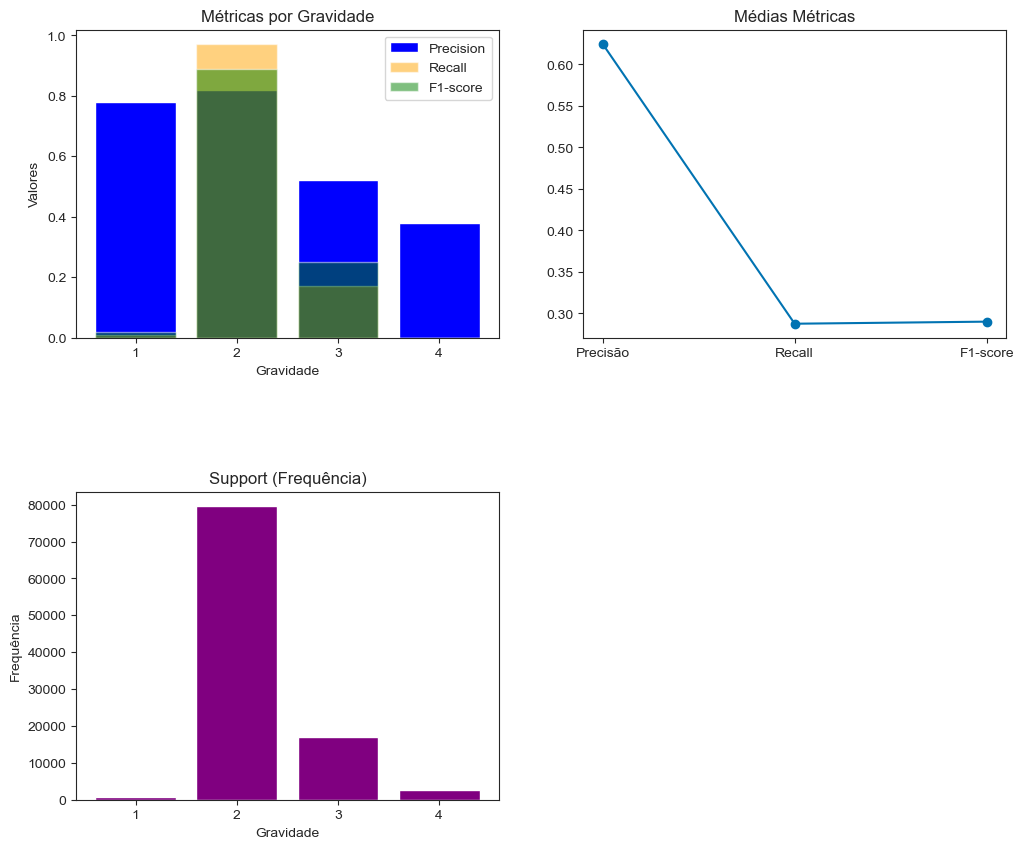

In [33]:
precision = [0.78, 0.82, 0.52, 0.38]
recall = [0.01, 0.97, 0.17, 0.00]
f1_score = [0.02, 0.89, 0.25, 0.00]
support = [832, 79519, 17070, 2575]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

severity = ['1', '2', '3', '4']
axs[0, 0].bar(severity, precision, color='blue', label='Precision')
axs[0, 0].bar(severity, recall, color='orange', label='Recall', alpha=0.5)
axs[0, 0].bar(severity, f1_score, color='green', label='F1-score', alpha=0.5)
axs[0, 0].set_title('Métricas por Gravidade')
axs[0, 0].set_xlabel('Gravidade')
axs[0, 0].set_ylabel('Valores')
axs[0, 0].legend()

mean_metrics = [np.mean(precision), np.mean(recall), np.mean(f1_score)]
axs[0, 1].plot(['Precisão', 'Recall', 'F1-score'], mean_metrics, marker='o')
axs[0, 1].set_title('Médias Métricas')

axs[1, 0].bar(severity, support, color='purple')
axs[1, 0].set_title('Support (Frequência)')
axs[1, 0].set_xlabel('Gravidade')
axs[1, 0].set_ylabel('Frequência')

axs[1, 1].axis('off')

plt.subplots_adjust(hspace=0.5)


## Avaliação do Modelo XGBClassifier

* O modelo XGBClassifier demonstrou uma precisão notável na previsão da gravidade dos acidentes, com uma precisão geral de aproximadamente 80%. No entanto, ao examinarmos mais de perto as métricas de precisão, recall e pontuação F1 para cada classe de gravidade, observamos resultados variados.

* É digno de nota que o modelo alcançou uma precisão de 82% na identificação de acidentes de gravidade grau 2, mas apresentou desempenho significativamente menor na previsão de outras classes, com uma precisão de apenas 38% para acidentes de gravidade grau 4.

* É importante enfatizar que, enquanto a precisão do modelo é alta em algumas classes, o recall é baixo para outras, indicando uma dificuldade em identificar corretamente casos nessas classes.

* Esses resultados sugerem a necessidade de uma análise adicional do desequilíbrio de classes no conjunto de dados e ajustes potenciais no modelo para melhorar a generalização para todas as classes de gravidade.

#### Contagem de Severidade em um gráfico de pizza

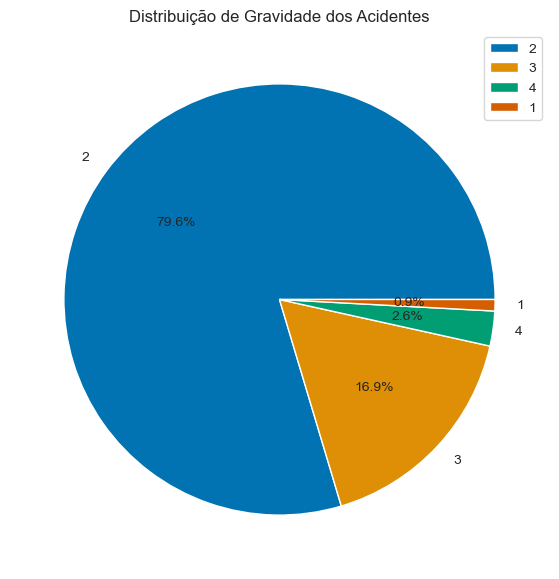

In [31]:
severity_count = df_copy_date2['Severity'].value_counts()

plt.figure(figsize=(10,7))
plt.pie(severity_count, labels=severity_count.index, autopct='%1.1f%%')
plt.legend()
plt.title('Distribuição de Gravidade dos Acidentes')
plt.show()

#### Conclusão:

* Os acidentes têm aumentado a cada ano, possivelmente devido ao crescimento da indústria automobilística.

* Estados com maior densidade populacional são mais propensos a ter mais acidentes.

* Recursos como cruzamento, interseção e parada estão presentes na maioria dos acidentes.

* É possível criar um modelo de aprendizado de máquina para prever a gravidade dos acidentes, mas não é totalmente preciso.

* Aberto a feedback e críticas.

* Obrigado! Estou apenas começando minha carreira no campo da análise de dados, então esta pode não ser a análise mais eficiente ainda. No entanto, estou comprometido com a melhoria contínua e aprendizado. Estou ansioso para evoluir e contribuir mais no futuro!